Gabriel Marcelino, Grant Burk, and Eli Kaustinen <br>
November 2024 <br>
GAN-Based Application <br>

## Problem Statement


The purpose of this project is to design a GAN-based application using Keras and TensorFlow that can generate fake images that look like real ones. The main idea is to train a GAN with a mix of real and fake images so it can learn to distinguish (discriminate) between them.


## Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt


## Preprocess data

In [2]:
def load_images(image_dir, img_size=(28, 28)):
    images = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = image.load_img(img_path, target_size=img_size, color_mode='grayscale')
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
        images.append(img)
    return np.array(images)

# Example usage
x_tr = load_images('portraits') 

## Build Generator

In [3]:
def build_generator(input_dimension, output_dimension):
    """    
    Parameters:
    - input_dimension: The size of the random noise vector (latent space input).
    - output_dimension: The size of the output vector (e.g., flattened image dimensions).
    """
    gen = Sequential()
    gen.add(Dense(256, input_dim=input_dimension))
    gen.add(LeakyReLU(0.2))
    gen.add(Dense (512))
    gen.add(LeakyReLU(0.2))
    gen.add(Dense (1024))
    gen.add(LeakyReLU(0.2))
    gen.add(Dense(output_dimension, activation='tanh'))

    return gen

generator = build_generator(100, 784)
generator.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-21 20:01:30.534057: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-21 20:01:30.534278: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-21 20:01:30.534631: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-21 20:01:30.534950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 20:01:30.535361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

## Build Discriminator

In [4]:
def build_discriminator(input_dimension):
    desc = Sequential()
    desc.add(Dense(1024, input_dim=input_dimension))
    desc.add(LeakyReLU(0.2))
    desc.add(Dropout(0.2))
    desc.add(Dense(512))
    desc.add(LeakyReLU(0.2))
    desc.add(Dropout(0.2))
    desc.add(Dense(256))
    desc.add(LeakyReLU(0.2))
    desc.add(Dense(1, activation='sigmoid'))

    return desc

discriminator = build_discriminator(784)
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

## Build GAN (Stack Generator and Discriminator)

In [5]:
def build_gan(gen, desc, input_dimension):
    # Make the Discriminator non-trainable when building the GAN
    desc.trainable = False

    # Create the input for the GAN, which is the noise vector fed to the Generator
    gan_input = Input(shape=(input_dimension, ))

    # Generate the fake image from the Generator
    gen_op = gen(gan_input)

    # Discriminator evaluates the fake image generated by the Generator
    desc_op = desc(gen_op)  # Use `desc` here, not `gen`

    # Build the GAN model, where the inputs are the noise vector, and the outputs are the Discriminator's judgment
    gan = Model(inputs=gan_input, outputs=desc_op)

    return gan

gan = build_gan(generator, discriminator, 100)


## Train GAN

In [6]:
def train_gan(gen, desc, x_tr, input_dimension, batch_size):
    noise = generate_noise(batch_size, input_dimension)

    # Generate fake images from the generator
    generated_images = gen.predict(noise)

    # Reshape generated images to match the shape of the real images
    generated_images = generated_images.reshape(batch_size, 28, 28, 1)

    # Select a random batch of real images from the training set
    image_batch = x_tr[np.random.randint(low=0, high=x_tr.shape[0], size=batch_size)]
    
    # Flatten the real and generated images
    image_batch = image_batch.reshape(batch_size, 784)  # Flatten real images
    generated_images = generated_images.reshape(batch_size, 784)  # Flatten generated images


    # Combine real images and generated images to form the training set for the discriminator
    X = np.concatenate([image_batch, generated_images])

    # Assign labels for the discriminator's training (real = 0.9, fake = 0.0)
    Y_desc = np.concatenate([np.ones(batch_size) * 0.9, np.zeros(batch_size)])

    # Set the discriminator to be trainable (if it was set to False earlier)
    desc.trainable = True

    # Train the discriminator on the batch of real and generated images
    desc.train_on_batch(X, Y_desc)


# Function to generate noise
def generate_noise(batch_size, input_dimension):
    return np.random.randn(batch_size, input_dimension)  # Gaussian noise


## Function to plot generated images to track progress

In [7]:
def plot_generated_images(epoch, gen, input_dimension, examples=10, dim=(1, 10), figsize=(10, 1)):
    # Generate random noise
    noise = generate_noise(examples, input_dimension)
    
    # Generate images from the noise
    generated_images = gen.predict(noise)
    
    # Rescale images to the range [0, 1] for visualization
    generated_images = (generated_images + 1) / 2  # Rescale from [-1, 1] to [0, 1]
    
    # Plot the generated images
    plt.figure(figsize=figsize)
    
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


## Run Training Loop 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 0/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


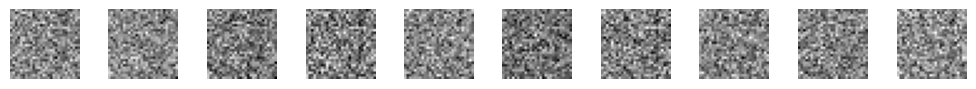

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 5/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


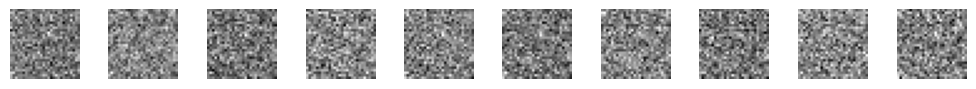

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 10/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


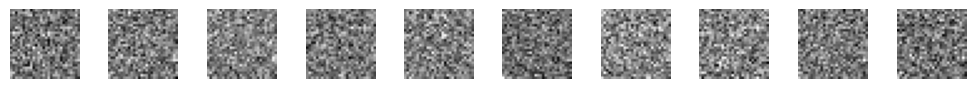

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 15/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


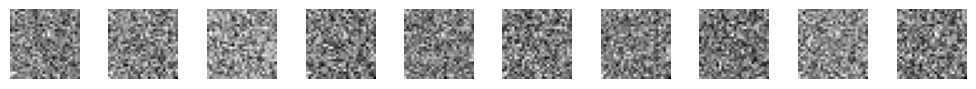

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 20/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


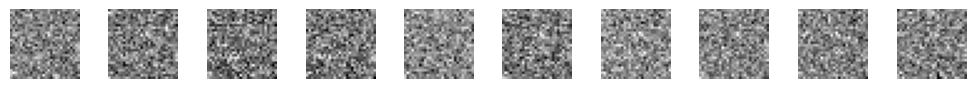

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 25/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


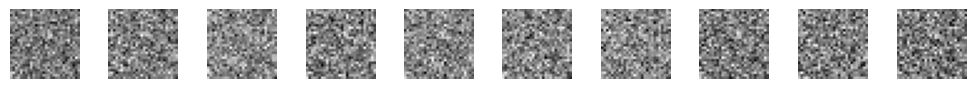

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 30/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


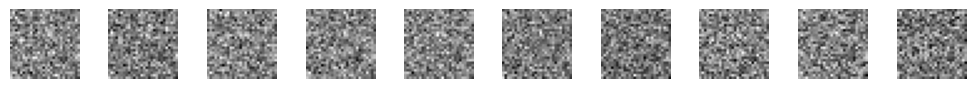

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 35/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


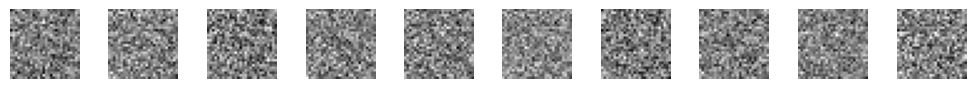

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 40/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


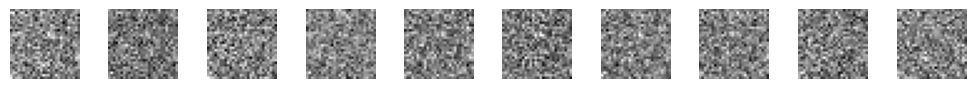

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 45/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


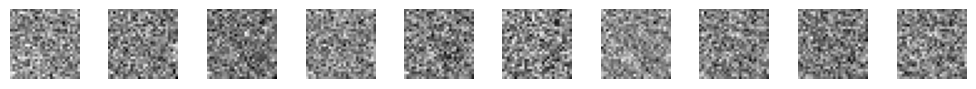

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 50/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


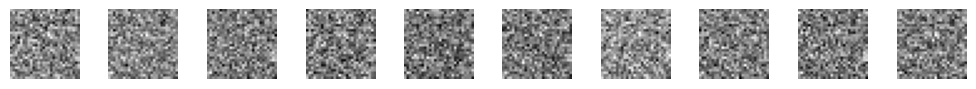

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 55/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


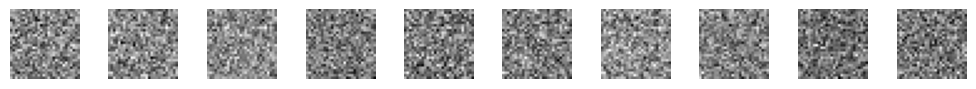

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 60/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


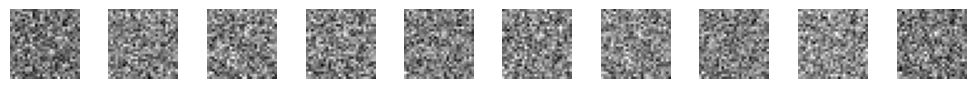

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 65/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


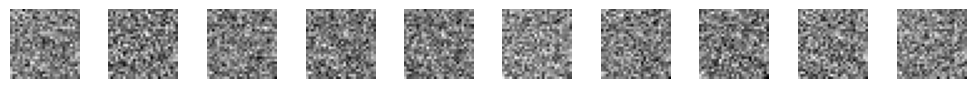

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 70/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


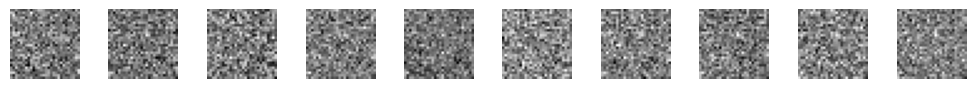

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 75/500 completed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


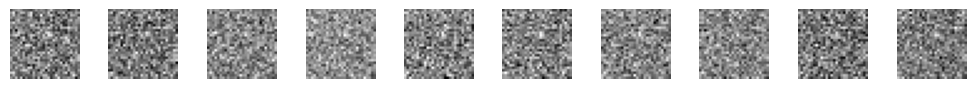

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


KeyboardInterrupt: 

In [12]:
# Compile models
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

epochs = 500
batch_size = 64
input_dimension = 100  # Size of the noise vector (input to the generator)

for epoch in range(epochs):
    train_gan(generator, discriminator, x_tr, input_dimension, batch_size)
    if epoch % 5 == 0:
        print(f'Epoch {epoch}/{epochs} completed')
        plot_generated_images(epoch, generator, input_dimension, examples=10, dim=(1, 10), figsize=(10, 1))


## References
https://kaushiklade27.medium.com/image-generation-using-generative-adversarial-networks-gans-cd82afd71597